d:\Anaconda\instullation\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10
300/300 ━━━━━━━━━━━━━━━━━━━━ 32s 84ms/step - accuracy: 0.8772 - loss: 0.4090 - val_accuracy: 0.9833 - val_loss: 0.0535
Epoch 2/10
300/300 ━━━━━━━━━━━━━━━━━━━━ 24s 80ms/step - accuracy: 0.9839 - loss: 0.0517 - val_accuracy: 0.9886 - val_loss: 0.0369
Epoch 3/10
300/300 ━━━━━━━━━━━━━━━━━━━━ 24s 79ms/step - accuracy: 0.9902 - loss: 0.0310 - val_accuracy: 0.9931 - val_loss: 0.0235
Epoch 4/10
300/300 ━━━━━━━━━━━━━━━━━━━━ 24s 79ms/step - accuracy: 0.9932 - loss: 0.0215 - val_accuracy: 0.9922 - val_loss: 0.0250
Epoch 5/10
300/300 ━━━━━━━━━━━━━━━━━━━━ 24s 79ms/step - accuracy: 0.9946 - loss: 0.0176 - val_accuracy: 0.9907 - val_loss: 0.0320
Epoch 6/10
300/300 ━━━━━━━━━━━━━━━━━━━━ 24s 80ms/step - accuracy: 0.9950 - loss: 0.0144 - val_accuracy: 0.9897 - val_loss: 0.0345
Epoch 7/10
300/300 ━━━━━━━━━━━━━━━━━━━━ 23s 78ms/step - accuracy: 0.9965 - loss: 0.0114 - val_accuracy: 0.9910 - val_loss: 0.0328
Epoch 8/10
300/300 ━━━━━━━━━━━━━━━━━━━━ 23s 77ms/step - accuracy: 0.9977 - loss: 0.0078 - 

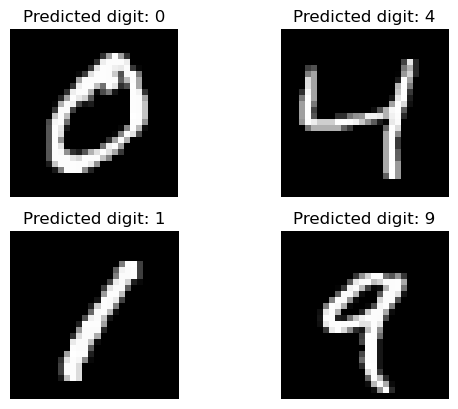

Saved model to disk


In [1]:
import numpy as np
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras import backend as K
import matplotlib.pyplot as plt
from keras.utils import to_categorical
from matplotlib import pyplot
from sklearn.model_selection import KFold

def input_data():
    # Load MNIST data
    (X_train, y_train), (X_test, y_test) = mnist.load_data()

    # Reshape to be samples*pixels*width*height
    X_train = X_train.reshape(X_train.shape[0], 28, 28, 1).astype('float32')
    X_test = X_test.reshape(X_test.shape[0], 28, 28, 1).astype('float32')

    # One hot encoding of labels
    y_train = to_categorical(y_train)
    y_test = to_categorical(y_test)

    # Normalize pixel values to the range [0, 1]
    X_train /= 255.0
    X_test /= 255.0

    return X_test, y_test, X_train, y_train

def create_model():
    # Create CNN model
    model = Sequential()
    model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', input_shape=(28, 28, 1)))
    model.add(MaxPooling2D((2, 2)))
    model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform'))
    model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Flatten())
    model.add(Dense(100, activation='relu', kernel_initializer='he_uniform'))
    model.add(Dense(10, activation='softmax'))

    # Compile model
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

def evaluate_model(X_train, y_train, n_folds=5):
    accuracy, data = [], []
    # Prepare 5-fold cross-validation
    kfold = KFold(n_folds, shuffle=True, random_state=1)
    for x_train, x_test in kfold.split(X_train):
        # Create model
        model = create_model()
        # Select rows for train and test
        trainX, trainY, testX, testY = X_train[x_train], y_train[x_train], X_train[x_test], y_train[x_test]
        # Fit model
        data_fit = model.fit(trainX, trainY, validation_data=(testX, testY), epochs=10, batch_size=32, verbose=0)
        # Evaluate model
        _, acc = model.evaluate(testX, testY, verbose=0)
        accuracy.append(acc)
        data.append(data_fit)
    return accuracy, data

def summarize_diagnostics(data):
    for i in range(len(data)):
        # Plot loss
        pyplot.subplot(2, 1, 1)
        pyplot.title('Cross Entropy Loss')
        pyplot.plot(data[i].history['loss'], color='red', label='train')
        pyplot.plot(data[i].history['val_loss'], color='orange', label='test')
        # Plot accuracy
        pyplot.subplot(2, 1, 2)
        pyplot.title('Classification Accuracy')
        pyplot.plot(data[i].history['accuracy'], color='blue', label='train')
        pyplot.plot(data[i].history['val_accuracy'], color='orange', label='test')
    pyplot.show()

def summarize_performance(acc):
    # Print summary
    print('Accuracy: mean=%.3f std=%.3f, n=%d' % (np.mean(acc) * 100, np.std(acc) * 100, len(acc)))
    # Box and whisker plot of results
    pyplot.boxplot(acc)
    pyplot.show()

def test(X_train, model):
    test_images = X_train[1:5]
    test_images = test_images.reshape(test_images.shape[0], 28, 28)

    for i, test_image in enumerate(test_images, start=1):
        org_image = test_image
        test_image = test_image.reshape(1, 28, 28, 1)
        prediction = np.argmax(model.predict(test_image), axis=-1)  # Update prediction

        print(f"Predicted digit: {prediction[0]}")
        plt.subplot(220 + i)
        plt.axis('off')
        plt.title(f"Predicted digit: {prediction[0]}")
        plt.imshow(org_image, cmap=plt.get_cmap('gray'))

    plt.show()

def run():
    X_test, y_test, X_train, y_train = input_data()

    # Evaluate model
    model = create_model()
    model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=10, batch_size=200)
    
    # Test prediction on the dataset
    test(X_train, model)

    # Save the model to disk
    model_json = model.to_json()
    with open("model.json", "w") as json_file:
        json_file.write(model_json)
    model.save_weights("model.weights.h5")  # Updated filename
    print("Saved model to disk")


# Run the program
run()

